In [1]:
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
device = 'cpu'
class StockPriceDataset(Dataset):
    def __init__(self,
                 data_path: str,
                 input_sequence: int,
                 output_sequence: int,
                 flag: str='train',
                 train_split: float = 0.6,
                 val_split: float = 0.2
                 ):
        """
        :param data_path: file path of the csv file
        :param input_sequence: window size for input
        :param output_sequence: horizon size for output
        :param flag: configure for data purpose like train or validation or test
        """
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence
        df = pd.read_csv(data_path, index_col=0)
        df.reset_index(drop=True, inplace=True)
        self.n_features = df.shape[1]
        num_train = int(len(df)*train_split)
        num_valid = int(len(df)*val_split)
        self.scaler = StandardScaler()
        self.scaler.fit_transform(df[:num_train].values)
        if flag == 'val':
            df = df[num_train-input_sequence:num_train+num_valid]
        elif flag == 'test':
            df = df[num_train+num_valid-input_sequence:]
        else:
            df = df[:num_train]
        self.data = torch.tensor(self.scaler.transform(df.values)).float()

    def __len__(self):
        return len(self.data) - self.input_sequence - self.output_sequence + 1

    def __getitem__(self, index):
        x_begin = index
        x_end = x_begin + self.input_sequence
        y_begin = x_end
        y_end = y_begin + self.output_sequence
        return self.data[x_begin: x_end], self.data[y_begin:y_end]



class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, stateful=False):
        """
        :param: N: int
            number of time series
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T

        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        self.sec_phase_lstm = nn.LSTMCell(input_size=self.N+1, hidden_size=self.M)

        #equation 8 matrices

        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)

        self.W_e2 = nn.Linear(2*self.M, self.T)
        self.U_e2 = nn.Linear(self.T, self.T, bias=False)
        self.v_e2 = nn.Linear(self.T, 1, bias=False)

    def forward(self, inputs, target_history):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M))
        x_tilde = torch.zeros((inputs.size(0), self.T, self.N))
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M))
        s_tm1 = torch.zeros((inputs.size(0), self.M))

        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)

            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))

            #normalize attention weights (equation 9)
            alpha_k_t = F.softmax(e_k_t, dim=1)

            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :]

            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            x_tilde[:, t, :] = weighted_inputs
            encoded_inputs[:, t, :] = h_tm1

        #second phase attention
        h_tm2 = torch.zeros((inputs.size(0), self.M))
        s_tm2 = torch.zeros((inputs.size(0), self.M))
        z = torch.cat((x_tilde, target_history), dim=2)
        z_tilde = torch.zeros((inputs.size(0), self.T, self.N+1))
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat_2 = torch.cat((h_tm2, s_tm2), dim=1)

            #attention weights for each k in N (equation 8)
            x2 = self.W_e2(h_c_concat_2).unsqueeze(1).repeat(1, self.N+1, 1)
            y2 = self.U_e2(z.permute(0, 2, 1))
            z2 = torch.tanh(x2 + y2)
            e_k_t2 = torch.squeeze(self.v_e2(z2))

            #normalize attention weights (equation 9)
            alpha_k_t2 = F.softmax(e_k_t2, dim=1)

            #weight inputs (equation 10)
            weighted_inputs2 = alpha_k_t2 * z[:, t, :]

            #calculate next hidden states (equation 11)
            h_tm2, s_tm2 = self.sec_phase_lstm(weighted_inputs2, (h_tm2, s_tm2))
            z_tilde[:, t, :] = weighted_inputs2
            encoded_inputs[:, t, :] = h_tm2

        return encoded_inputs

class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, pred_len, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful

        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)

        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)

        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)

        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, pred_len)

    def forward(self, encoded_inputs, y):

        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P))
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P))
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)

            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)

            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)

            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)

            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))

        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1

class DSTP_RNN(nn.Module):
    def __init__(self, N, M, P, T, pred_len, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, stateful_encoder)
        self.decoder = TemporalAttentionDecoder(M, P, T, pred_len, stateful_decoder)
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history, y_history), y_history)
        return out


hidden_size = 256
num_layers = 1
learning_rate = 0.001
epochs = 100
input_sequence = 20
output_sequence = 1
batch_size=128
train_dataset = StockPriceDataset('VN30_price.csv', input_sequence, output_sequence)
val_dataset = StockPriceDataset('VN30_price.csv', input_sequence, output_sequence, flag='val')
test_dataset = StockPriceDataset('VN30_price.csv', input_sequence, output_sequence, flag='test')
n_features = train_dataset.n_features


class Optim(object):

    def _makeOptimizer(self):
        if self.method == 'sgd':
            self.optimizer = optim.SGD(self.params, lr=self.lr)
        elif self.method == 'adagrad':
            self.optimizer = optim.Adagrad(self.params, lr=self.lr)
        elif self.method == 'adadelta':
            self.optimizer = optim.Adadelta(self.params, lr=self.lr)
        elif self.method == 'adam':
            self.optimizer = optim.Adam(self.params, lr=self.lr)
        else:
            raise RuntimeError("Invalid optim method: " + self.method)

    def __init__(self, params, method, lr, max_grad_norm, lr_decay=1, start_decay_at=None):
        self.params = list(params)  # careful: params may be a generator
        self.last_ppl = None
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.method = method
        self.lr_decay = lr_decay
        self.start_decay_at = start_decay_at
        self.start_decay = False

        self._makeOptimizer()

    def step(self):
        # Compute gradients norm.
        grad_norm = 0
        for param in self.params:
            grad_norm += math.pow(param.grad.data.norm(), 2)

        grad_norm = math.sqrt(grad_norm)
        if grad_norm > 0:
            shrinkage = self.max_grad_norm / grad_norm
        else:
            shrinkage = 1.

        for param in self.params:
            if shrinkage < 1:
                param.grad.data.mul_(shrinkage)

        self.optimizer.step()
        return grad_norm

    # decay learning rate if val perf does not improve or we hit the start_decay_at limit
    def updateLearningRate(self, ppl, epoch):
        if self.start_decay_at is not None and epoch >= self.start_decay_at:
            self.start_decay = True
        if self.last_ppl is not None and ppl > self.last_ppl:
            self.start_decay = True

        if self.start_decay:
            self.lr = self.lr * self.lr_decay
            print("Decaying learning rate to %g" % self.lr)
        #only decay for one epoch
        self.start_decay = False

        self.last_ppl = ppl

        self._makeOptimizer()

model = DSTP_RNN(n_features, hidden_size, hidden_size, input_sequence, output_sequence)
criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), learning_rate)
optimizer = Optim(model.parameters(), 'adam', learning_rate, 10)
model.train()
best_loss = 10000000000000000
for epoch in range(epochs):
    test_loss = 0
    n_item = 0
    for i, (input, true_output) in enumerate(DataLoader(train_dataset, batch_size=batch_size)):
        model.zero_grad()
        x = input[:, :, :]
        y_history = input[:, :, -1:]
        output = model(x, y_history)
        # true_output = torch.squeeze(true_output[:, :, [0]], 1)
        true_output = true_output[:, :, -1]
        loss = criterion(output, true_output)
        test_loss += loss.item()
        n_item += 1
        # optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('epoch number {}, iter {}, LOSS {}'.format(epoch+1, i+1, test_loss/n_item) )
    if (epoch+1) % 10 == 0:
        print (f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')
        pred = []
        true = []
        for i, (input, true_output) in enumerate(DataLoader(val_dataset, batch_size=batch_size)):
            model.eval()
            model.zero_grad()
            x = input[:, :, :]
            y_history = input[:, :, -1:]
            output = model(x, y_history)
            # true_output = torch.squeeze(true_output, 1)
            pred_price = output.detach().numpy()
            # pred_price = output.squeeze().detach().numpy()
            true_price = true_output[:, :, -1].detach().numpy()
            pred.extend(pred_price)
            true.extend(true_price)
        print('Val RMSE')
        print(np.sqrt(np.mean((np.array(pred)-np.array(true))**2)))


epoch number 1, iter 7, LOSS 1.0256800513182367
epoch number 2, iter 7, LOSS 0.9494147226214409
epoch number 3, iter 7, LOSS 0.9411891262446132
epoch number 4, iter 7, LOSS 0.9331144168972969
epoch number 5, iter 7, LOSS 0.9182633523430143
epoch number 6, iter 7, LOSS 0.8772816216307027
epoch number 7, iter 7, LOSS 0.698202303477696
epoch number 8, iter 7, LOSS 0.30402889422007967
epoch number 9, iter 7, LOSS 0.6460082594837461
epoch number 10, iter 7, LOSS 0.509522445499897
Epoch [10], Loss: 0.3476
Val RMSE
1.7272615
epoch number 11, iter 7, LOSS 0.2322433026773589
epoch number 12, iter 7, LOSS 0.2953620675419058
epoch number 13, iter 7, LOSS 0.2981118660952364
epoch number 14, iter 7, LOSS 0.29015769836093697
epoch number 15, iter 7, LOSS 0.09574277220027787
epoch number 16, iter 7, LOSS 0.09426059613802604
epoch number 17, iter 7, LOSS 0.11102147879345077
epoch number 18, iter 7, LOSS 0.17659046075173787
epoch number 19, iter 7, LOSS 0.13224234219108308
epoch number 20, iter 7, LOSS

In [2]:
print("Result ================================")
pred = []
true = []
for i, (input, true_output) in enumerate(DataLoader(test_dataset, batch_size=300)):
    model.eval()
    model.zero_grad()
    x = input[:, :, :]
    y_history = input[:, :, -1:]
    output = model(x, y_history)
    # true_output = torch.squeeze(true_output, 1)
    pred_price = output.detach().tolist()
    pred.extend(pred_price)
    # pred_price = output.squeeze().detach().numpy()
    true_price = true_output[:, :, -1].detach().tolist()
    true.extend(true_price)

# print(pred_price)
# print(true_price)

# %%


Result ================================


In [3]:
df = pd.read_csv('VN30_price.csv', index_col=0)


In [4]:
scaler = StandardScaler()
scaler.fit_transform(df[:int(0.6*len(df))].loc[:, ['VN30']].values)

array([[-1.99762082e+00],
       [-1.94926813e+00],
       [-1.95939836e+00],
       [-1.94126610e+00],
       [-1.92841177e+00],
       [-1.91087541e+00],
       [-1.90270312e+00],
       [-1.86839654e+00],
       [-1.87810113e+00],
       [-1.89665903e+00],
       [-1.95939836e+00],
       [-1.91819641e+00],
       [-1.95599324e+00],
       [-1.97387012e+00],
       [-1.94594814e+00],
       [-1.93624355e+00],
       [-1.90304363e+00],
       [-1.85647862e+00],
       [-1.78675880e+00],
       [-1.80208184e+00],
       [-1.77782036e+00],
       [-1.75696400e+00],
       [-1.74427993e+00],
       [-1.73695893e+00],
       [-1.73738457e+00],
       [-1.70418465e+00],
       [-1.69780005e+00],
       [-1.64970274e+00],
       [-1.66128015e+00],
       [-1.65804528e+00],
       [-1.66264219e+00],
       [-1.62893151e+00],
       [-1.65370376e+00],
       [-1.66383399e+00],
       [-1.71159079e+00],
       [-1.67404934e+00],
       [-1.74445019e+00],
       [-1.76113528e+00],
       [-1.7

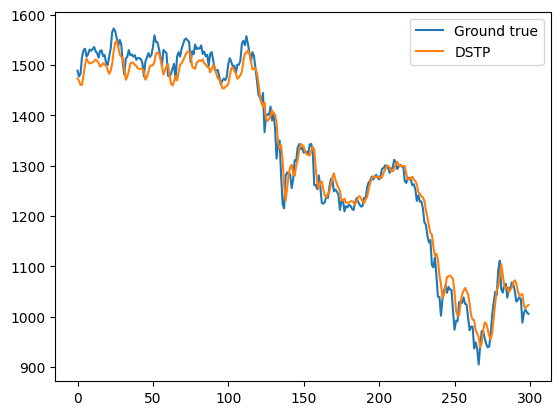

RMSE
26.760332392473597


In [5]:
import matplotlib.pyplot as plt
rescaled_true = scaler.inverse_transform(np.array(true))
rescaled_pred = scaler.inverse_transform(np.array(pred))
plt.plot(rescaled_true[:, 0], label="Ground true")
plt.plot(rescaled_pred[:, 0], label="DSTP")
plt.legend()
plt.show()
print('RMSE')
print(np.sqrt(np.mean((rescaled_pred-rescaled_true)**2)))


In [6]:
np.array(true)[:, 0].shape

(300,)

In [7]:
print(rescaled_pred[:, 0])

[1473.22309085 1468.155547   1460.43550925 1460.57644084 1480.25992406
 1500.46153813 1512.07545531 1506.83617209 1502.76500789 1504.10570649
 1505.03722175 1507.42118384 1510.80914349 1508.12595383 1503.83863104
 1496.61538275 1499.6473725  1503.51873424 1500.21978107 1498.73999934
 1489.84372052 1482.4120996  1488.44415104 1502.70075966 1527.8445019
 1544.79415867 1547.21419386 1536.85297706 1520.22691402 1516.56493316
 1513.06360087 1493.62590774 1470.53917301 1476.61693199 1487.3226358
 1502.63057393 1504.97190926 1504.57028782 1500.00636717 1498.35254949
 1492.96040366 1491.99158298 1492.34172741 1492.04193969 1487.81746477
 1470.82966237 1476.00161659 1486.1822998  1497.75689505 1499.05916795
 1499.25919447 1506.38256953 1522.64840559 1524.55675156 1521.91260376
 1512.21868348 1496.50481083 1480.69380964 1490.13124113 1497.73034434
 1501.53068015 1478.88332038 1463.16631093 1459.08747279 1466.63145808
 1478.09693778 1469.30411708 1485.18804869 1500.03336599 1503.07437402
 1508.78

In [9]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def adjust(val, length= 6): return str(val).ljust(length)

In [10]:
accuracy_prod = forecast_accuracy(rescaled_true[:, 0], rescaled_pred[:, 0])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  0.0164
me     :  1.6193
mae    :  21.0864
mpe    :  -0.0003
rmse   :  26.7603
corr   :  0.9933
minmax :  0.0163
